In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
import scipy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import DarkNews as dn
from DarkNews import const
from DarkNews.GenLauncher import GenLauncher
from DarkNews import Cfourvec as Cfv
from DarkNews.MC import get_merged_MC_output
from DarkNews.fourvec import df_dot3

from particle import literals as lp
from pathlib import Path

import ToyAnalysis as ta
from ToyAnalysis import analysis_decay as ad
from ToyAnalysis import analysis as an
from ToyAnalysis import fit_functions as fit
from ToyAnalysis.plot_tools import plot_all_rates as MBplotter
from pathlib import Path


def get_pval(df_prob, ndof=8.7):
    bin_e = np.genfromtxt(f'ToyAnalysis/data/MB_data_release/nue2020/numode/miniboone_binboundaries_nue_lowe.txt')
    NP_MC, _ = np.histogram(df_prob['reco_Enu']*1e3, weights=df_prob['reco_w'], bins=bin_e)
    bw = bin_e[1:]-bin_e[:-1]
    # plt.step((bin_e[1:]+bin_e[:-1])/2,NP_MC/bw, where ='mid')
    chi2=fit.chi2_MiniBooNE_2020(NP_MC, NP_MC.sum())
    return scipy.stats.chi2.sf(chi2, ndof)

def print_summary_of_event(df, col='w_event_rate', summary='Events'):
    coherent = (df['scattering_regime'] == 'coherent')
    pel = (df['scattering_regime'] == 'p-el')
    nel = (df['scattering_regime'] == 'n-el')
    print(f"{summary}: {df[col].sum():.2g} total ({df[col][coherent].sum():.2g} coh : {df[col][pel].sum():.2g} pel : {df[col][nel].sum():.2g} nel)")


## Generating events for benchmarks

In [3]:
common_kwargs = {'loglevel': 'ERROR', 'HNLtype': 'dirac', 'neval': 1e4}

# TMM
kwargs = {'mu_tr_mu4': 1.4e-6, 'm4': 0.470, 'decay_product': 'photon'}
gen_1 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_1_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
genmuB_1 = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
genmuB_1_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_1 = gen_1.run()
df_1_dirt = gen_1_dirt.run()
df_1_muB = genmuB_1.run()
df_1_muB_dirt = genmuB_1_dirt.run()

# Vectors
M4 = 0.107
M5 = 0.150
kwargs = {'d_mu5': 0.0002, 'd_45': 1, 'dprotonV': 3.4e-4*const.eQED, 'deV': 3.4e-4*const.eQED, 'mzprime': 0.03, 'm4': M4, 'm5': M5}
gen_2 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_2_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
gen_2_muB = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
gen_2_muB_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_2 = gen_2.run()
df_2_dirt = gen_2_dirt.run()
df_2_muB = gen_2_muB.run()
df_2_muB_dirt = gen_2_muB_dirt.run()

kwargs = {'d_mu5': 0.0002, 'd_45': 1, 'dprotonV': 3.4e-4*const.eQED, 'deV': 3.4e-4*const.eQED, 'mzprime': 0.03, 'm4': M4, 'm5': M5}
kwargs = {'UD4': 1/np.sqrt(2), 'UD5': 1/np.sqrt(2), 'Umu5': 1e-3, 'Umu4': 1e-3, 'gD': 2, 'epsilon': 0.75e-2, 'mzprime': 1.25, 'm4': M4, 'm5': M5}
gen_3 = dn.GenLauncher(experiment='miniboone_fhc',  **kwargs, **common_kwargs)
gen_3_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt',  **kwargs, **common_kwargs)
gen_3_muB = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
gen_3_muB_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_3 = gen_3.run()
df_3_dirt = gen_3_dirt.run()
df_3_muB = gen_3_muB.run()
df_3_muB_dirt = gen_3_muB_dirt.run()

# Scalars
M4 = 0.140
M5 = 0.2
theta_e = 2.5e-3
theta_numu = 4e-3
theta_nucleon = 4e-3
kwargs = {'mzprime': None, 'mhprime': 1.0, 'm4': M4, 'm5': M5, 's_mu5': theta_numu, 's_45': 1.0,  'deS': theta_e, 'dprotonS': theta_nucleon, 'dneutronS': theta_nucleon}
gen_4 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_4_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
gen_4_muB = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
gen_4_muB_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_4 = gen_4.run()
df_4_dirt = gen_4_dirt.run()
df_4_muB = gen_4_muB.run()
df_4_muB_dirt = gen_4_muB_dirt.run()


theta_e = 0.8e-3
theta_numu = 1e-3
theta_nucleon = 1.4e-4
kwargs = {'mzprime': None, 'mhprime': 0.03, 'm4': M4, 'm5': M5, 's_mu5': theta_numu, 's_45': 1.0,  'deS': theta_e, 'dprotonS': theta_nucleon, 'dneutronS': theta_nucleon}
gen_5 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_5_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
gen_5_muB = dn.GenLauncher(experiment='microboone',**kwargs, **common_kwargs)
gen_5_muB_dirt = dn.GenLauncher(experiment='microboone_dirt',**kwargs, **common_kwargs)
df_5 = gen_5.run()
df_5_dirt = gen_5_dirt.run()
df_5_muB = gen_5_muB.run()
df_5_muB_dirt = gen_5_muB_dirt.run()


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/model.py:591: RuntimeWarning: invalid value encountered in sqrt
  self.le_state_norms = np.sqrt(1 - np.sum((self.Ulep.conjugate()*self.Ulep)[:,3:], axis=1))


### Performing analysis

Apply decay probability, smear, select overlapping and asymmetric events for

* MiniBooNE 
* MicroBooNE

In [76]:
my_dfs = [df_1, df_2, df_3, df_4, df_5]
my_dfs_dirt = [df_1_dirt, df_2_dirt, df_3_dirt, df_4_dirt, df_5_dirt]
my_dfs_muB = [df_1_muB, df_2_muB, df_3_muB, df_4_muB, df_5_muB]
my_dfs_muB_dirt = [df_1_muB_dirt, df_2_muB_dirt, df_3_muB_dirt, df_4_muB_dirt, df_5_muB_dirt]

##########
# MiniBooNE -- smear, signal selection and filter decays
my_dfs_prob = []
my_dfs_dirt_prob = []
final_dfs = []
for df, dfd in zip(my_dfs, my_dfs_dirt):
    if df.attrs['model'].mu_tr_mu4 > 0:
        dfp   = an.compute_spectrum(ad.decay_selection(df, l_decay_proper_cm=df.attrs['N4_ctau0'], experiment='miniboone'), EVENT_TYPE='photon')
        dfp_d = an.compute_spectrum(ad.decay_selection(dfd, l_decay_proper_cm=dfd.attrs['N4_ctau0'], experiment='miniboone'), EVENT_TYPE='photon')
    else:
        dfp   = an.compute_spectrum(ad.decay_selection(df, l_decay_proper_cm=df.attrs['N5_ctau0'], experiment='miniboone'), EVENT_TYPE='both')
        dfp_d = an.compute_spectrum(ad.decay_selection(dfd, l_decay_proper_cm=dfd.attrs['N5_ctau0'], experiment='miniboone'), EVENT_TYPE='both')
    my_dfs_prob.append(dfp)
    my_dfs_dirt_prob.append(dfp_d)
    final_dfs.append(get_merged_MC_output(dfp,dfp_d))

##########
# MicroBooNE -- smear, signal selection and filter decays
my_dfs_muB_prob = []
my_dfs_muB_dirt_prob = []
final_dfs_muB = []
for df, dfd in zip(my_dfs_muB, my_dfs_muB_dirt):
    if df.attrs['model'].mu_tr_mu4 > 0:
        dfp   = an.compute_spectrum(ad.decay_selection(df, l_decay_proper_cm=df.attrs['N4_ctau0'], experiment='microboone'), EVENT_TYPE='photon', EXP='microboone')
        dfp_d = an.compute_spectrum(ad.decay_selection(dfd, l_decay_proper_cm=dfd.attrs['N4_ctau0'], experiment='microboone'), EVENT_TYPE='photon', EXP='microboone')
    else:
        dfp   = an.compute_spectrum(ad.decay_selection(df, l_decay_proper_cm=df.attrs['N5_ctau0'], experiment='microboone'), EVENT_TYPE='both', EXP='microboone')
        dfp_d = an.compute_spectrum(ad.decay_selection(dfd, l_decay_proper_cm=dfd.attrs['N5_ctau0'], experiment='microboone'), EVENT_TYPE='both', EXP='microboone')
    my_dfs_muB_prob.append(dfp)
    my_dfs_muB_dirt_prob.append(dfp_d)
    final_dfs_muB.append(get_merged_MC_output(dfp,dfp_d))

/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis_decay.py:80: RuntimeWarning: invalid value encountered in sqrt
  M = np.sqrt(dot4(p.T, p.T))
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:296: RuntimeWarning: invalid value encountered in sqrt
  Pe  = np.sqrt(Evis**2 - const.m_e**2)
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis_decay.py:80: RuntimeWarning: invalid value encountered in sqrt
  M = np.sqrt(dot4(p.T, p.T))
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:296: RuntimeWarning: invalid value encountered in sqrt
  Pe  = np.sqrt(Evis**2 - const.m_e**2)
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:304: RuntimeWarning: invalid value encountered in double_scalars
  eff = weights[final_selected].sum()/weights.sum()
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis_decay.py:80: RuntimeWarning: invalid

### Some tests

### Position of upscattering

(3.150701735421535e-05, 109.42112880831013)

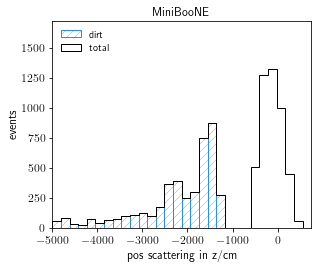

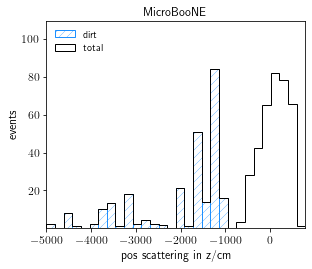

In [167]:

fig, ax = dn.plot_tools.std_fig()
df = final_dfs[2]
dirt_mask = (df['pos_scatt','3']<-610)
position = df['pos_scatt','3']
tmax = position.max()*1.3
tmin = -5e3 #position.min()
nbins = 31

_ = ax.hist(position[dirt_mask], weights=df['w_event_rate'][dirt_mask], bins=np.linspace(tmin,tmax, nbins), histtype='bar', 
                hatch='///', facecolor='None', edgecolor='dodgerblue', label='dirt')
ht,_,_ = ax.hist(position, weights=df['w_event_rate'], bins=np.linspace(tmin,tmax, nbins), histtype='step', color='black',
            label='total')
ax.set_title("MiniBooNE")
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel("pos scattering in z/cm")
ax.set_ylabel("events")
ax.set_xlim(tmin,tmax)
ax.set_ylim(0,ht.max()*1.3)


fig, ax = dn.plot_tools.std_fig()
df = final_dfs_muB[2]
dirt_mask = (df['pos_scatt','3']<-1100/2-215)
position = df['pos_scatt','3']
tmax = position.max()*1.3
tmin = -5e3 #position.min()
nbins = 31

_ = ax.hist(position[dirt_mask], weights=df['w_event_rate'][dirt_mask], bins=np.linspace(tmin,tmax, nbins), histtype='bar', 
                hatch='///', facecolor='None', edgecolor='dodgerblue', label='dirt')
ht,_,_ = ax.hist(position, weights=df['w_event_rate'], bins=np.linspace(tmin,tmax, nbins), histtype='step', color='black',
            label='total')

ax.set_title("MicroBooNE")
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel("pos scattering in z/cm")
ax.set_ylabel("events")
ax.set_xlim(tmin,tmax)
ax.set_ylim(ht.min(),ht.max()*1.3)


(0.0, 153.59139088100832)

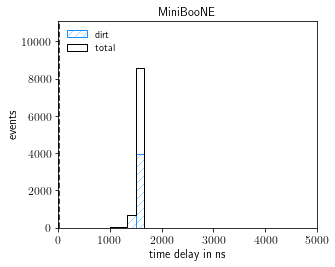

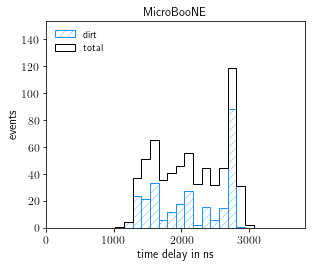

In [181]:
# df = final_dfs[2]
# dirt_mask = (df['pos_scatt','3']<-610)
# delay = (df['pos_decay','0'] - np.min(df['pos_decay','0']))*1e9
# tmax = 100 #delay.max()*1.01
# tmin = delay.min()



fig, ax = dn.plot_tools.std_fig()
df = final_dfs[2]
dirt_mask = (df['pos_scatt','3']<-610)
position = (df['pos_scatt','0'] - np.min(df['pos_scatt','0']))*1e9
tmax = 5000
tmin = position.min()
nbins = 31

_ = ax.hist(position[dirt_mask], weights=df['w_event_rate'][dirt_mask], bins=np.linspace(tmin,tmax, nbins), histtype='bar', 
                hatch='///', facecolor='None', edgecolor='dodgerblue', label='dirt')
ht,_,_ = ax.hist(position, weights=df['w_event_rate'], bins=np.linspace(tmin,tmax, nbins), histtype='step', color='black',
            label='total')
ax.set_title("MiniBooNE")
ax.vlines(10,0,1e5, colors='black', ls='--')
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel("time delay in ns")
ax.set_ylabel("events")
ax.set_xlim(tmin,tmax)
ax.set_ylim(0,ht.max()*1.3)


fig, ax = dn.plot_tools.std_fig()
df = final_dfs_muB[2]
dirt_mask = (df['pos_scatt','3']<-1100/2-215)
position = (df['pos_scatt','0'] - np.min(df['pos_scatt','0'])) ## already in ns....
tmax = position.max()*1.3
tmin = 0 #position.min()
nbins = 31

_ = ax.hist(position[dirt_mask], weights=df['w_event_rate'][dirt_mask], bins=np.linspace(tmin,tmax, nbins), histtype='bar', 
                hatch='///', facecolor='None', edgecolor='dodgerblue', label='dirt')
ht,_,_ = ax.hist(position, weights=df['w_event_rate'], bins=np.linspace(tmin,tmax, nbins), histtype='step', color='black',
            label='total')

ax.set_title("MicroBooNE")
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel("time delay in ns")
ax.set_ylabel("events")
ax.set_xlim(tmin,tmax)
ax.set_ylim(ht.min(),ht.max()*1.3)


1.6747374607806831e-07


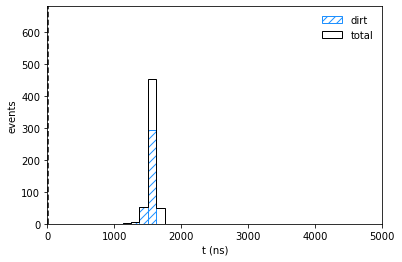

In [90]:
df = final_dfs[2]
dirt_mask = (df['pos_scatt','3']<-610)
delay = (df['pos_scatt','0'] - np.min(df['pos_scatt','0']))*1e9
tmax = 5000 #delay.max()*1.01
tmin = delay.min()

_ = plt.hist(delay[dirt_mask], weights=df['reco_w'][dirt_mask], bins=np.linspace(tmin,tmax, 41), histtype='bar', 
                hatch='///', facecolor='None', edgecolor='dodgerblue', label='dirt')
ht,_,_ = plt.hist(delay, weights=df['reco_w'], bins=np.linspace(tmin,tmax, 41), histtype='step', color='black',
            label='total')
plt.vlines(10,0,1e3, colors='black', ls='--')
plt.legend(loc='upper right', frameon=False)
plt.xlabel("t (ns)")
plt.ylabel("events")
plt.xlim(tmin,tmax)
plt.ylim(0,ht.max()*1.5)

print(df['pos_scatt','0'].min())

In [93]:
## Printing summary for MiniBooNE benchmarks 

for i, (df, df_mub) in enumerate(zip(final_dfs,final_dfs_muB)):
    if i>0:
        print(f'\nBenchmark {i+1}: mzprime = {df.attrs["model"].mzprime}, mhprime = {df.attrs["model"].mhprime}')
        print(f"{df.attrs['N5_ctau0']}")

    else:
        print(f'\nBenchmark {i+1}: transition mag moment')
        print(f"ctau0 = {df.attrs['N4_ctau0']:2g} cm")

    print_summary_of_event(df, col='w_pre_decay',summary='Raw events at MiniBooNE')
    print_summary_of_event(df, col='reco_w', summary='Selected events at MiniBooNE')
    print(f'MiniBooNE p-value: {get_pval(df)}')
    print_summary_of_event(df_mub, col='w_pre_decay',summary='Raw events at MicroBooNE')


Benchmark 1: transition mag moment
ctau0 = 2.43698 cm
Raw events at MiniBooNE: 2.5e+05 total (1.9e+05 coh : 6.1e+04 pel : 0 nel)
Selected events at MiniBooNE: 7e+02 total (2.5e+02 coh : 4.5e+02 pel : 0 nel)
MiniBooNE p-value: 0.4147300946927827
Raw events at MicroBooNE: 2.5e+06 total (1.2e+06 coh : 1.2e+06 pel : 0 nel)

Benchmark 2: mzprime = 0.03, mhprime = None
5.072332304320809e-12
Raw events at MiniBooNE: 1.4e+06 total (1.3e+06 coh : 1.3e+05 pel : 0 nel)
Selected events at MiniBooNE: 6.6e+02 total (5.3e+02 coh : 1.3e+02 pel : 0 nel)
MiniBooNE p-value: 0.42819963207413647
Raw events at MicroBooNE: 6e+06 total (5.4e+06 coh : 6e+05 pel : 0 nel)

Benchmark 3: mzprime = 1.25, mhprime = None
183.22293216098657
Raw events at MiniBooNE: 2.4e+05 total (1.8e+05 coh : 6.1e+04 pel : 0 nel)
Selected events at MiniBooNE: 5.6e+02 total (2.5e+02 coh : 3.1e+02 pel : 0 nel)
MiniBooNE p-value: 0.30964029486617384
Raw events at MicroBooNE: 4.8e+06 total (2.1e+06 coh : 2.7e+06 pel : 0 nel)

Benchmark 

MB events: 7e+02
MB events: 6.6e+02
MB events: 5.6e+02
MB events: 7.6e+02
MB events: 7.3e+02


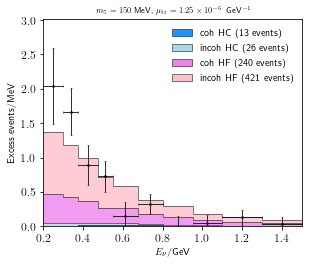

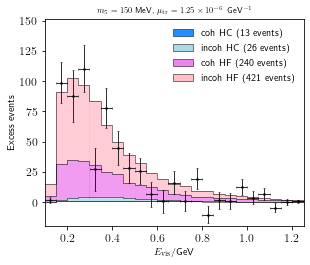

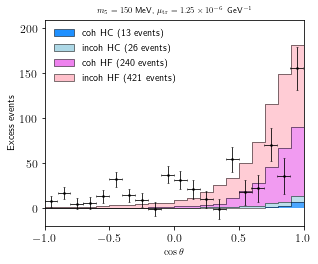

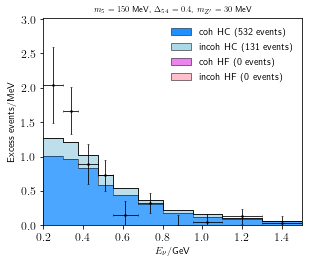

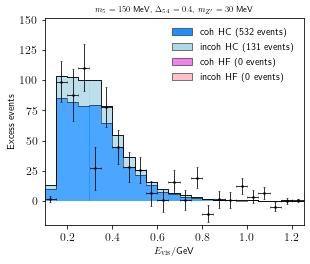

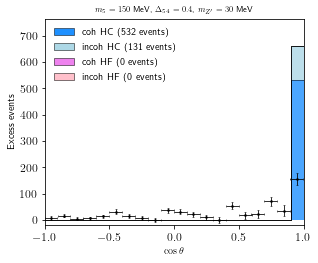

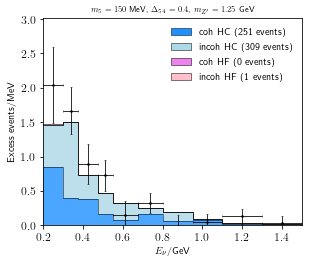

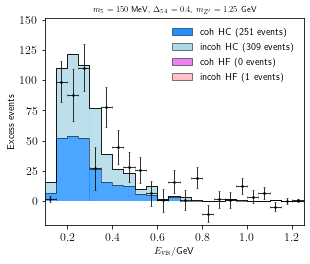

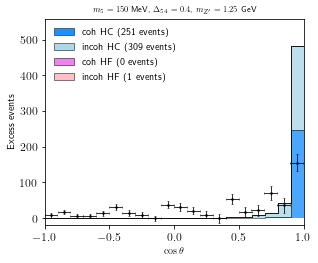

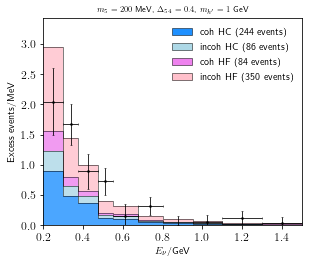

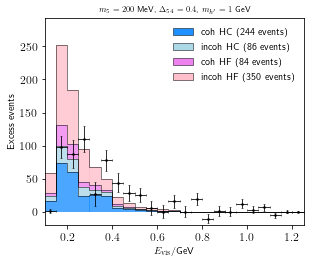

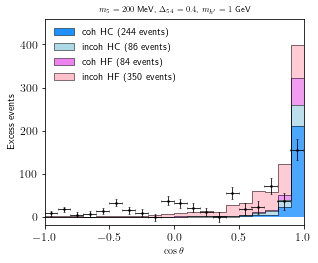

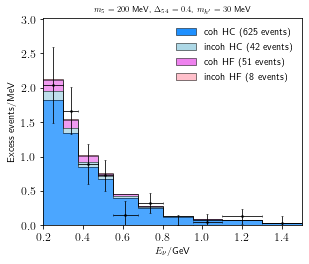

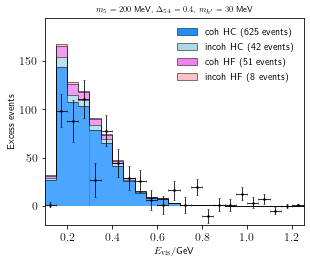

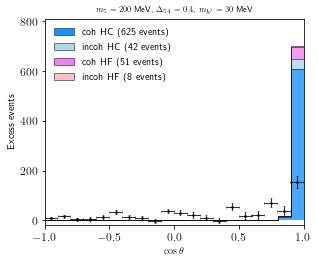

In [184]:
ta.plot_tools.batch_plot_signalMB(final_dfs[0], PATH='plots/BP0', title=r'$m_5 = 150$ MeV,  $\mu_{\rm tr} = 1.25 \times 10^{-6}$ GeV$^{-1}$', prefix='BP0')
ta.plot_tools.batch_plot_signalMB(final_dfs[1], PATH='plots/BP1', title=r'$m_5 = 150$ MeV,  $\Delta_{54} = 0.4$,  $m_{Z^\prime} = 30$ MeV', prefix='BP1')
ta.plot_tools.batch_plot_signalMB(final_dfs[2], PATH='plots/BP2', title=r'$m_5 = 150$ MeV,  $\Delta_{54} = 0.4$,  $m_{Z^\prime} = 1.25$ GeV', prefix='BP2')
ta.plot_tools.batch_plot_signalMB(final_dfs[3], PATH='plots/BP3', title=r'$m_5 = 200$ MeV,  $\Delta_{54} = 0.4$,  $m_{h^\prime} = 1$ GeV', prefix='BP3')
ta.plot_tools.batch_plot_signalMB(final_dfs[4], PATH='plots/BP4', title=r'$m_5 = 200$ MeV,  $\Delta_{54} = 0.4$,  $m_{h^\prime} = 30$ MeV', prefix='BP4')

In [94]:
# Im missing the miniboone plots for TMM

MBplotter(final_dfs[1], 'BP light vector', title='$m_5 = 150$ MeV,  $\Delta_{54} = 0.4$,  $m_{Z^\prime} = 30$ MeV')
MBplotter(final_dfs[2], 'BP heavy vector', title='$m_5 = 150$ MeV,  $\Delta_{54} = 0.4$,  $m_{Z^\prime} = 1.25$ GeV')
MBplotter(final_dfs[3], 'BP light scalar', title='$m_5 = 200$ MeV,  $\Delta_{54} = 1$,  $m_{h^\prime} = 30$ MeV')
MBplotter(final_dfs[4], 'BP heavy scalar', title='$m_5 = 200$ MeV,  $\Delta_{54} = 1$,  $m_{h^\prime} = 1.0$ MeV')

/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis_decay.py:80: RuntimeWarning: invalid value encountered in sqrt
  M = np.sqrt(dot4(p.T, p.T))


TypeError: batch_plot_signalMB() got an unexpected keyword argument 'BP'

# Test the geometries a bit

In [8]:

# geometry of muBoone
#cryostat vessel
r_muB = 191.61
l_muB  = 1086.49
#detector
z_muB = 1040.
x_muB = 256.
y_muB = 232.
dif_z = l_muB - z_muB
#outer spheres
r_s_muB = 305.250694958
theta_lim_muB = 38.8816337686 * np.pi / 180.0
#how much volume for each - rates
sphere_cut_muB = 0.030441980173709752
cylinder_cut_muB = 1. - 2*sphere_cut_muB

precision = 1e-8
def get_distances(p0, phat, experiment):
    """get_distances_in_muB gets the distance to the entry and exit 
    of the MicroBooNE fiducial volume

    NOTE: this function uses a coordinate system with (0,0,0) being the center 
    of the MicroBooNE detector in the xy plane AND the most upstream point of the 
    detector in the z position (the tip of the first spherical cap).

    Parameters
    ----------
    p0 : np.ndarray
        point of HNL production
    phat : np.ndarray
        direction of travel of HNL
    experiment :
        what experiment to find the distances for 'microboone', 'sbnd'

    Returns
    -------
    2 np.ndarrays
        one array for the distance of entry and one for the exit
    """

    # number of events
    n = len(p0.T)

    # positions of the 6 walls of the cryostat in order (2 for X, 2 for Y, 2 for Z)
    if experiment == 'microboone':
        planes = np.array([-x_muB/2,x_muB/2,-y_muB/2,y_muB/2,dif_z/2,z_muB + dif_z/2])
    elif experiment == 'sbnd':
        planes = np.array([-x_sbnd/2,x_sbnd/2,-y_sbnd/2,y_sbnd/2,dif_z_sbnd/2,z_sbnd + dif_z_sbnd/2])

    # suitable forms for parameters
    p0_6 = np.array([p0[0], p0[0], p0[1], p0[1], p0[2], p0[2]]).T
    phat_6 = np.array([phat[0], phat[0], phat[1], phat[1], phat[2], phat[2]]).T

    # find solutions and intersections of P0 + phat*t = planes, for parameter t
    solutions = (planes - p0_6) / phat_6
    # intersections = [[p0[:,i] + solutions[i,j] * phat[:,i] for j in range(6)] for i in range(n)]
    intersections = [p0 + solutions[:,j] * phat for j in range(6)]


    # create a mask with invalid intersections
    mask_inter = np.array([[
        (planes[0] - precision <= intersections[i][j][0] <= planes[1] + precision)\
      & (planes[2] - precision <= intersections[i][j][1] <= planes[3] + precision)\
      & (planes[4] - precision <= intersections[i][j][2] <= planes[5] + precision)\
      & (solutions[i,j] > -precision) for j in range(6)] for i in range(n)])

    # compute the distances from the previous calculations
    distances = np.zeros((n,2))
    for i in range(n):
        dist_temp = solutions[i][mask_inter[i]]
        if len(dist_temp) == 2:
            distances[i] = dist_temp
        elif len(dist_temp) == 1:
            distances[i] = [0, dist_temp[0]]
        else:
            distances[i] = [0,0]

    # return the distances
    return distances

In [9]:
d2, d1 = get_distances(p0, phat, 'microboone')

NameError: name 'p0' is not defined

In [10]:
pN = df.P_decay_N_parent.values
l_decay_lab_cm = ta.analysis_decay.get_decay_length_in_lab(pN, df.attrs['N5_ctau0'])
# direction of travel of the HNL.
phat = ta.analysis_decay.get_3direction(pN)

# production point
p0 = np.array([df['pos_scatt','1'], df['pos_scatt','2'], df['pos_scatt','3']])




d2, d1 = get_distances(p0, phat, 'microboone').T

np.sum(d1 - d2)


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
plt.hist(np.exp(-d2/l_decay_lab_cm) - np.exp(-d1/l_decay_lab_cm))
